In [90]:
import os
import pandas as pd
import numpy as np
import preprocessor as prep
import postprocessor as postp
import processor as proc
import pandas as pd
import unifloc.uniflocpy.uTools.plotly_workflow as pw
import datetime
from sklearn import metrics
import multiprocessing as mp
from multiprocessing import Pool
from preprocessor import load_and_edit_chess_data
import seaborn as sns

from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from pandas.api.types import is_numeric_dtype

В этой тетрадке разберёмся с `фильтрацией`.

Для начала зафиксируем время замера, меньше которого всё плохо, по нашему мнению  и посмотрим графики, а также долю данных, которую придётся отбросить

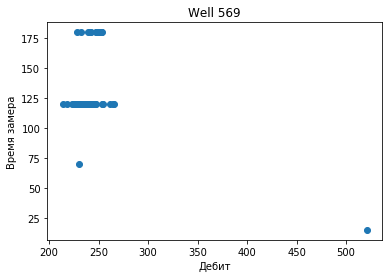

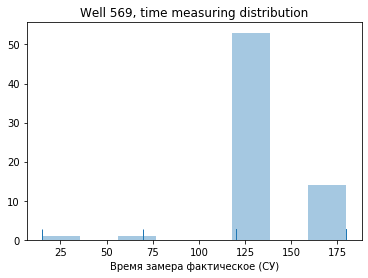

well 569, data loss on measuring time
1.4492753623188406%


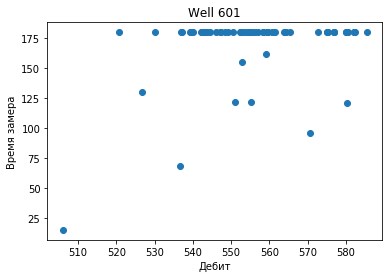

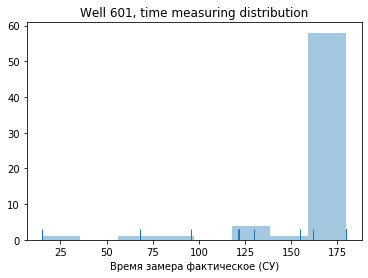

well 601, data loss on measuring time
1.5151515151515151%


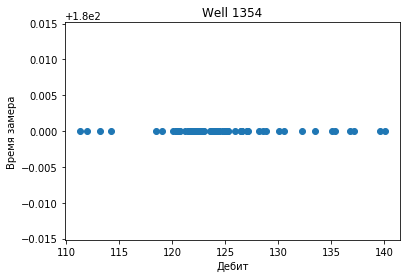

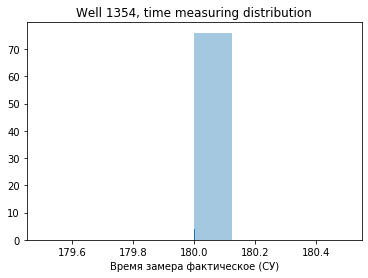

well 1354, data loss on measuring time
0.0%


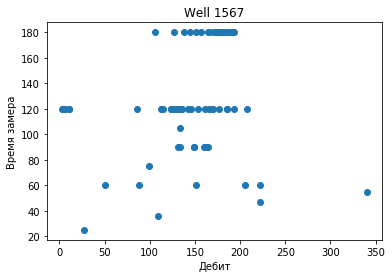

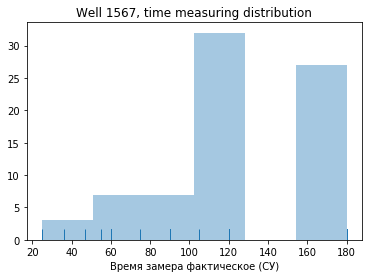

well 1567, data loss on measuring time
3.9473684210526314%


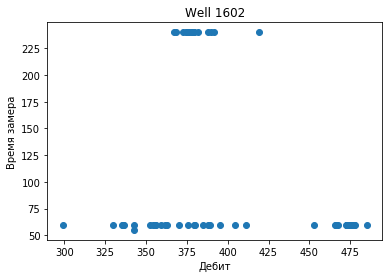

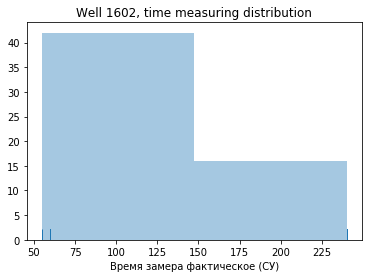

well 1602, data loss on measuring time
0.0%


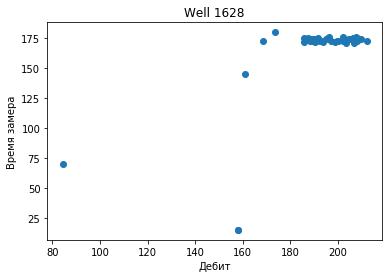

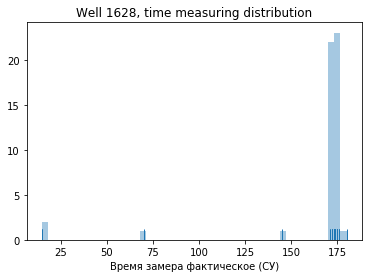

well 1628, data loss on measuring time
4.0%


In [91]:
time_err = 55
for well_name in well_names:
    ad_inp = pd.read_csv(f'data/{well_name}/adapt_input{mark}/{well_name}_adapt_input.csv')
    plt.scatter(ad_inp['Объемный дебит жидкости (СУ)'], ad_inp['Время замера фактическое (СУ)'])
    plt.xlabel('Дебит')
    plt.ylabel('Время замера')
    plt.title('Well '+well_name)
    plt.show()
    sns.distplot(ad_inp['Время замера фактическое (СУ)'], kde=False, rug=True);
    plt.title('Well '+well_name+', time measuring distribution')
    plt.show()
    s = 0.
    for i in ad_inp['Время замера фактическое (СУ)']:
        if i < time_err:
            s += 1
    print(f'well {well_name}, data loss on measuring time\n{s/len(ad_inp["Время замера фактическое (СУ)"])*100}%')

Понятно, что ничего не понятно, для разных скважин нужно выставить разные порги. Так, например, на скважне `1567` имеетют место реально плохие точи, котрые нужно выкалывать, а на скважне `1602` больше половины данных замерены за 60мин

In [92]:
critical_time_well = {'569': 30,
                      '601': 30,
                      '1354': 30,
                      '1567': 30,
                      '1602': 30,
                      '1628': 30
                     }

В первом приближении отсечём данные по времени замера. И сразу же сохраним данные

Well 569
Critical measuring time=30


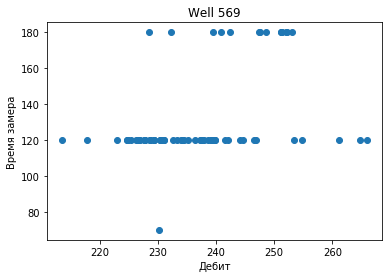

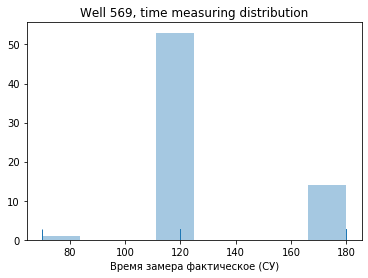

Well 601
Critical measuring time=30


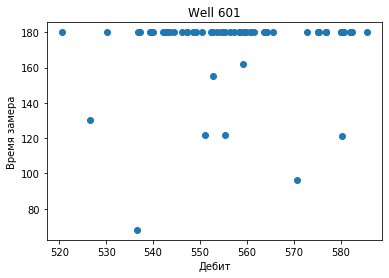

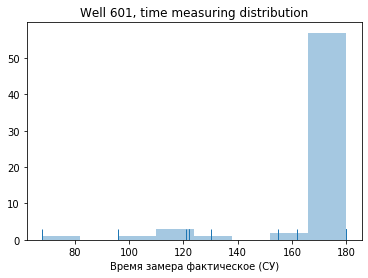

Well 1354
Critical measuring time=30


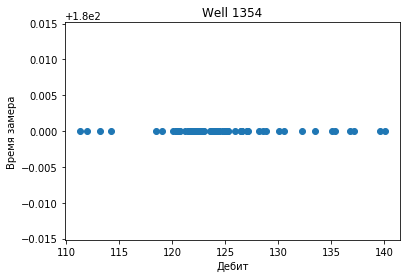

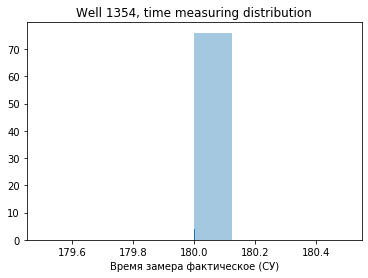

Well 1567
Critical measuring time=30


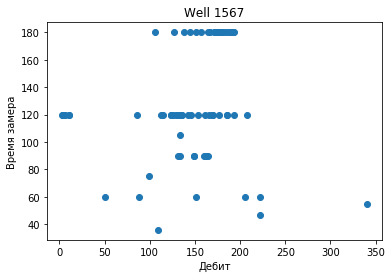

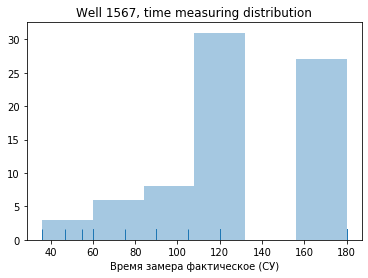

Well 1602
Critical measuring time=30


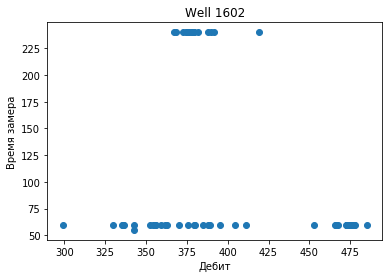

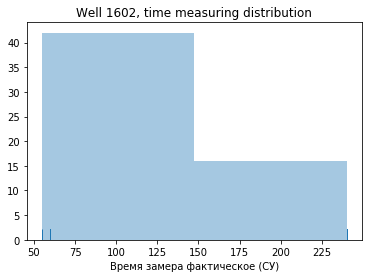

Well 1628
Critical measuring time=30


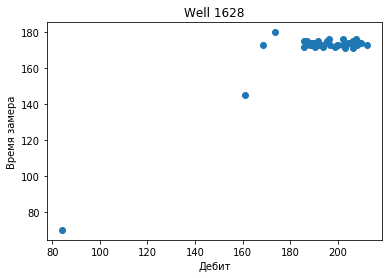

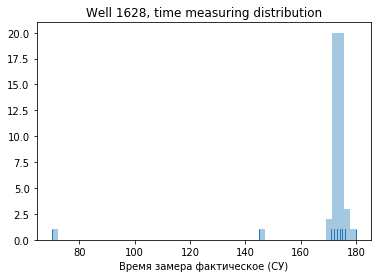

In [96]:
for well_name in well_names:
    time_err = critical_time_well[well_name]
    print(f'Well {well_name}\nCritical measuring time={time_err}')
    ad_inp = pd.read_csv(f'data/{well_name}/adapt_input{mark}/{well_name}_adapt_input.csv')
    #ad_inp = ad_inp[ad_inp['Время замера фактическое (СУ)'] > time_err]
    debt = ad_inp['Объемный дебит жидкости (СУ)']
    measuring = ad_inp['Время замера фактическое (СУ)']
    plt.scatter(debt, measuring)
    plt.xlabel('Дебит')
    plt.ylabel('Время замера')
    plt.title('Well '+well_name)
    plt.show()
    sns.distplot(measuring, kde=False, rug=True);
    plt.title('Well '+well_name+', time measuring distribution')
    plt.show()
    ad_inp.to_csv(f'data/{well_name}/adapt_input{mark}/{well_name}_adapt_input.csv')

В первом приближении построим функцию, которая очищает данные, по выставленной границе по замерам